In [71]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

In [25]:
path2patch = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patches_nb.npy"
path2patchposition = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patch_positions_nb.npy"
path2prediction = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/predicted_labels.npy"
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg'

patch = np.load(path2patch)
patchposition = np.load(path2patchposition)
prediction = np.load(path2prediction)
image = cv2.cvtColor(cv2.imread(path2img, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)


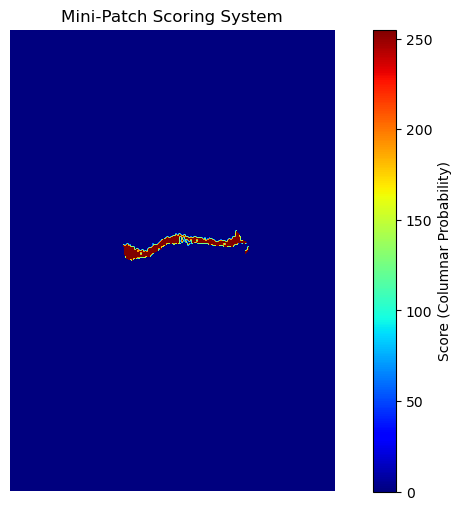

In [28]:
# Patch and mini-patch sizes
patch_size = 64
mini_patch_size = 32
stride = mini_patch_size  # Move by 32 pixels

# Get original image size from the patch positions
orig_h = image.shape[0] # np.max(patchposition[:, 0]) + patch_size
orig_w = image.shape[1] # np.max(patchposition[:, 1]) + patch_size

# Initialize score and count maps
mini_h, mini_w = orig_h // mini_patch_size, orig_w // mini_patch_size
score_map = np.zeros((mini_h, mini_w), dtype=np.float32)
count_map = np.zeros((mini_h, mini_w), dtype=np.int32)

# Iterate through patches
for (y, x), pred in zip(patchposition, prediction):
    # Convert 64x64 patch into 32x32 mini-patches
    for i in range(0, patch_size, stride):
        for j in range(0, patch_size, stride):
            mini_y = (y + i) // mini_patch_size
            mini_x = (x + j) // mini_patch_size

            # Update score map (Class 1 contributes +1, Class 0 contributes 0)
            score_map[mini_y, mini_x] += pred  # Adds 1 if class 1, 0 if class 0
            count_map[mini_y, mini_x] += 1  # Track coverage

# Normalize by count map (avoid division by zero)
mask = count_map > 0
score_map[mask] /= count_map[mask]

# Normalize for visualization
normalized_score_map = (score_map - score_map.min()) / (score_map.max() - score_map.min()) * 255
normalized_score_map = normalized_score_map.astype(np.uint8)

# Display final score map
plt.figure(figsize=(10, 6))
plt.imshow(normalized_score_map, cmap="jet", interpolation="nearest")
plt.colorbar(label="Score (Columnar Probability)")
plt.axis("off")
plt.title("Mini-Patch Scoring System")
plt.show()


In [33]:
normalized_score_map.shape, score_map.shape, count_map.shape

((476, 334), (476, 334), (476, 334))

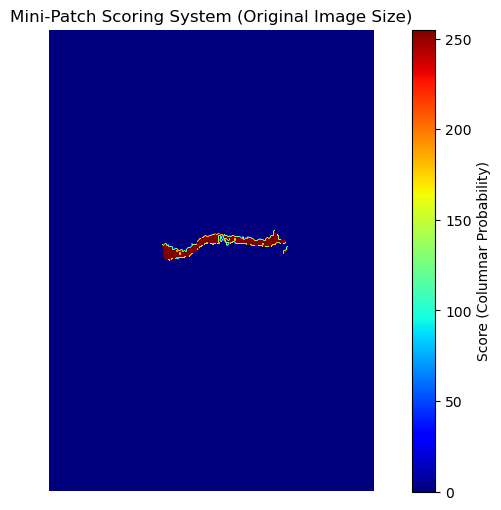

In [35]:
# Patch and mini-patch sizes
patch_size = 64
mini_patch_size = 32
stride = mini_patch_size  # Move by 32 pixels

# Get original image size from patch positions
orig_h = image.shape[0]
orig_w = image.shape[1]

# Initialize score and count maps with original image size
score_map = np.zeros((orig_h, orig_w), dtype=np.float32)
count_map = np.zeros((orig_h, orig_w), dtype=np.int32)

# Iterate through patches
for (y, x), pred in zip(patchposition, prediction):
    # Process each 64×64 patch in 32×32 mini-patches
    for i in range(0, patch_size, stride):
        for j in range(0, patch_size, stride):
            mini_y = y + i
            mini_x = x + j

            # Update score map (Class 1 contributes +1, Class 0 contributes 0)
            score_map[mini_y:mini_y+mini_patch_size, mini_x:mini_x+mini_patch_size] += pred
            count_map[mini_y:mini_y+mini_patch_size, mini_x:mini_x+mini_patch_size] += 1

# Normalize by count map (avoid division by zero)
mask = count_map > 0
score_map[mask] /= count_map[mask]

# Normalize for visualization
normalized_score_map = (score_map - score_map.min()) / (score_map.max() - score_map.min()) * 255
normalized_score_map = normalized_score_map.astype(np.uint8)

# Display final score map
plt.figure(figsize=(10, 6))
plt.imshow(normalized_score_map, cmap="jet", interpolation="nearest")
plt.colorbar(label="Score (Columnar Probability)")
plt.axis("off")
plt.title("Mini-Patch Scoring System (Original Image Size)")
plt.show()


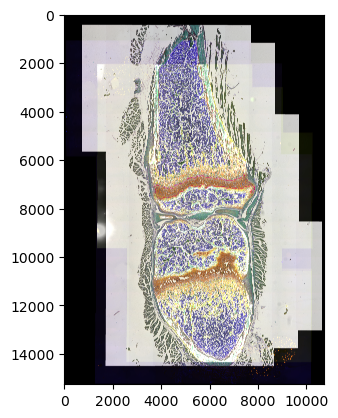

In [65]:
# Overlap mask on the image
one = np.where(count_map==1)
two = np.where(count_map==2)
three = np.where(count_map==3)
four = np.where(count_map==4)

overlap_img = np.copy(image)
overlap_img[one] += (0.3 * np.array([0.0, 255.0, 0.0])).astype(np.uint8)
overlap_img[two] += (0.6 * np.array([0.0, 255.0, 0.0])).astype(np.uint8)
overlap_img[three] += (0.9 * np.array([0.0, 255.0, 0.0])).astype(np.uint8)
overlap_img[four] += np.array([255, 0, 0]).astype(np.uint8)

Image.fromarray(overlap_img).save("/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/scoring_sys.png")
plt.imshow(overlap_img)
plt.show()


In [76]:
# Ensure image is float32 for blending
overlay_img = image.astype(np.float32)

# Create a mask where count_map > 2 (overlapping regions)
mask = count_map == 1

# Define the overlay color (Red for overlap)
overlay_color = np.array([255.0, 0.0, 0.0], dtype=np.float32)  # Red

# Apply overlay with 50% transparency
overlay_img[mask] = overlay_img[mask] * 0.5 + overlay_color * 0.5

# Clip values to [0, 255] and convert back to uint8
overlay_img = np.clip(overlay_img, 0, 255).astype(np.uint8)

# Save the overlaid image
overlay_path = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/scoring_sys.png"
Image.fromarray(overlay_img).save(overlay_path)


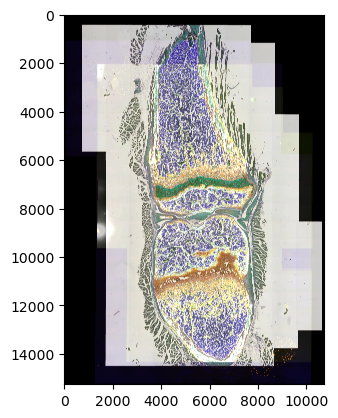

In [77]:
# Ensure image is float32 for blending
overlay_img = image.astype(np.float32)

# Create a mask where count_map > 2 (overlapping regions)
mask = count_map == 1

# Define the overlay color (Red for overlap)
overlay_color = np.array([255.0, 0.0, 0.0], dtype=np.float32)  # Red

# Apply overlay with 50% transparency
overlay_img[mask] = overlay_img[mask] * 0.5 + overlay_color * 0.5

# Clip values to [0, 255] and convert back to uint8
overlay_img = np.clip(overlay_img, 0, 255).astype(np.uint8)

plt.imshow(overlap_img)
plt.show()


In [85]:
e,c = np.unique(scored_reconstructed_image, return_counts=True)
e, c

(array([  0,  63,  85, 127, 255], dtype=uint8),
 array([488574352,   1298432,    125952,    192512,    130048]))

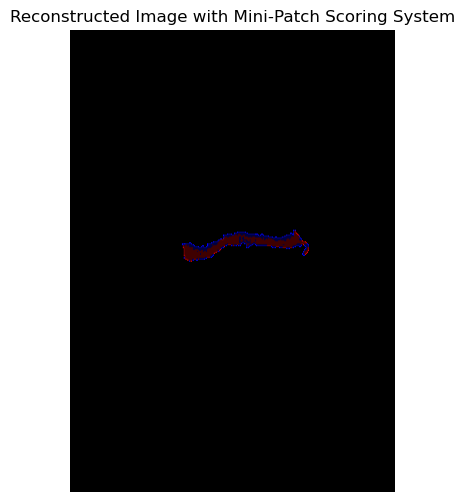

In [84]:
# Re-import necessary libraries after execution state reset
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_image_with_scoring(image_shape, patches, positions, labels, patch_size=64, mini_patch_size=32):
    """
    Reconstruct an image using the scoring system with patch_size/2 mini-patches.

    Args:
        image_shape (tuple): The shape of the original image (H, W, C).
        patches (np.array): Array of extracted patches.
        positions (list): List of (y, x) coordinates for each patch.
        labels (np.array): Classification labels for each patch (0: non-columnar, 1: columnar).
        patch_size (int): The size of the original patches.
        mini_patch_size (int): The size of the mini-patches (default is patch_size/2).

    Returns:
        reconstructed_image (np.array): Reconstructed image with color overlay.
    """
    h, w, c = image_shape

    # Initialize reconstructed image and count map
    reconstructed_image = np.zeros((h, w, c), dtype=np.uint8)
    count_map = np.zeros((h, w), dtype=np.uint8)

    # Color mapping for labels
    columnar_color = np.array([255, 0, 0], dtype=np.uint8)   # Red for columnar
    non_columnar_color = np.array([0, 0, 255], dtype=np.uint8)  # Blue for non-columnar

    # Iterate over patches and apply mini-patch system
    for (y, x), label in zip(positions, labels):
        color = columnar_color if label == 1 else non_columnar_color

        # Apply to mini-patches within each patch
        for i in range(0, patch_size, mini_patch_size):
            for j in range(0, patch_size, mini_patch_size):
                mini_y, mini_x = y + i, x + j

                # Assign color overlay to the mini-patch
                reconstructed_image[mini_y:mini_y+mini_patch_size, mini_x:mini_x+mini_patch_size] = color
                count_map[mini_y:mini_y+mini_patch_size, mini_x:mini_x+mini_patch_size] += 1

    # Normalize overlapping areas by averaging
    mask = count_map > 0
    reconstructed_image[mask] //= count_map[mask, None]

    return reconstructed_image

# Run reconstruction with scoring-based mini-patches
scored_reconstructed_image = reconstruct_image_with_scoring(image.shape, patch, patchposition, prediction)

# Display the reconstructed image
plt.figure(figsize=(10, 6))
plt.imshow(scored_reconstructed_image)
plt.axis("off")
plt.title("Reconstructed Image with Mini-Patch Scoring System")
plt.show()


In [87]:
overlay_img = scored_reconstructed_image * 0.5 + image.astype(np.float32)

# Clip values to [0, 255] and convert back to uint8
overlay_img = np.clip(overlay_img, 0, 255).astype(np.uint8)
Image.fromarray(overlay_img).save("/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/scored_recon.png")

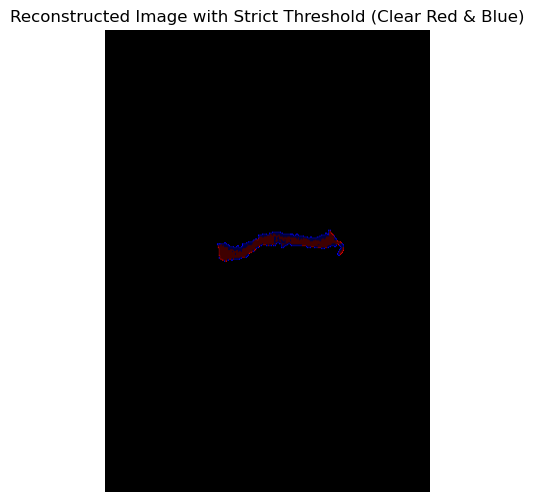

In [86]:
# Re-import necessary libraries after execution reset
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_image_with_strict_threshold(image_shape, positions, labels, patch_size=64, mini_patch_size=32):
    """
    Reconstruct an image with a strict threshold where:
      - Areas with >2 overlapping patches are Blue (Non-Columnar)
      - Others are Red (Columnar)

    Args:
        image_shape (tuple): The shape of the original image (H, W, C).
        positions (list): List of (y, x) coordinates for each patch.
        labels (np.array): Classification labels for each patch (0: non-columnar, 1: columnar).
        patch_size (int): The size of the original patches.
        mini_patch_size (int): The size of the mini-patches (default is patch_size/2).

    Returns:
        reconstructed_image (np.array): Reconstructed image with clear class distinction.
    """
    h, w, c = image_shape

    # Initialize reconstructed image and count map
    reconstructed_image = np.zeros((h, w, c), dtype=np.uint8)
    count_map = np.zeros((h, w), dtype=np.uint8)

    # Iterate over patches and apply mini-patch system
    for (y, x), label in zip(positions, labels):
        # Apply to mini-patches within each patch
        for i in range(0, patch_size, mini_patch_size):
            for j in range(0, patch_size, mini_patch_size):
                mini_y, mini_x = y + i, x + j

                # Increment count map for overlap tracking
                count_map[mini_y:mini_y+mini_patch_size, mini_x:mini_x+mini_patch_size] += 1

    # Apply strict thresholding:
    # If count_map > 2 → Blue (Non-Columnar), Else → Red (Columnar)
    blue_mask = count_map > 2  # Areas with high overlap
    red_mask = ~blue_mask       # Remaining areas

    # Assign colors
    reconstructed_image[red_mask] = [255, 0, 0]  # Red (Columnar)
    reconstructed_image[blue_mask] = [0, 0, 255]  # Blue (Non-Columnar)

    return reconstructed_image

# Run reconstruction with strict thresholding
scored_reconstructed_image = reconstruct_image_with_scoring(image.shape, patch, patchposition, prediction)


# Display the reconstructed image
plt.figure(figsize=(10, 6))
plt.imshow(scored_reconstructed_image)
plt.axis("off")
plt.title("Reconstructed Image with Strict Threshold (Clear Red & Blue)")
plt.show()
